# Employing XGBoost Model

### Installing and importing necessary packages

In [1]:
# install ucimlrepo
!pip install ucimlrepo

In [2]:
# install xgboost
!pip install xgboost

In [3]:
# import necessary packages
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")  # default style
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from keras import metrics
from scipy.stats import chi2_contingency
from xgboost import XGBClassifier

from ucimlrepo import fetch_ucirepo

2024-12-10 23:31:38.065035: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Importing data

In [4]:
# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
X = mushroom.data.features
y = mushroom.data.targets

# drop some of the columns
X = X.drop(columns=['odor', 'stalk-root', 'ring-type', 'spore-print-color', 'population', 'habitat'])

### One-hot encode the features

In [5]:
# One-Hot Encoding of categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Encode the target variable (assuming 'p' = poisonous, 'e' = edible)
y_series = y.squeeze()
y_encoded = y_series.apply(lambda x: 1 if x == 'p' else 0)

### Split into train and test sets

In [6]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# view shape for X_train, y_train, X_test, and y_test
print('X train:', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)


X train: (6499, 60)
y train (6499,)
X test (1625, 60)
y test (1625,)


### Train the model

In [7]:
# Initialize the XGBoost classifier
xgb_model = XGBClassifier(
    use_label_encoder=False,  # Avoids label encoding warning
    eval_metric='logloss',   # Metric to evaluate during training
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

/Users/saamiabashir/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:33:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Make predictions

In [8]:
# Make predictions
y_pred_3 = xgb_model.predict(X_test)

### Evaluate the model

In [9]:
# Evaluate the model
accuracy_3 = accuracy_score(y_test, y_pred_3)
precision_3 = precision_score(y_test, y_pred_3)
recall_3 = recall_score(y_test, y_pred_3)
f1_3 = f1_score(y_test, y_pred_3)

# show accuracy, precision, recall, and F1 score
print("XGBoost Model Evaluation:")
print(f"Accuracy: {accuracy_3:.4f}")
print(f"Precision: {precision_3:.4f}")
print(f"Recall: {recall_3:.4f}")
print(f"F1 Score: {f1_3:.4f}")


XGBoost Model Evaluation:
Accuracy: 0.9969
Precision: 0.9949
Recall: 0.9987
F1 Score: 0.9968


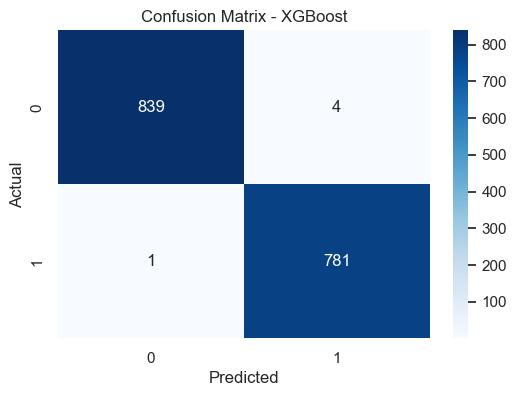

In [10]:
# show confusion Matrix
cm_3 = confusion_matrix(y_test, y_pred_3)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

### Hyperparameter tuning of the model

In [11]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    verbose=1
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the tuned model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)

# show the accuracy of tuned model 
print(f"Tuned Model Accuracy: {accuracy_tuned:.4f}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits


/Users/saamiabashir/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/saamiabashir/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/saamiabashir/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/saamiabashir/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Tuned Model Accuracy: 0.9969


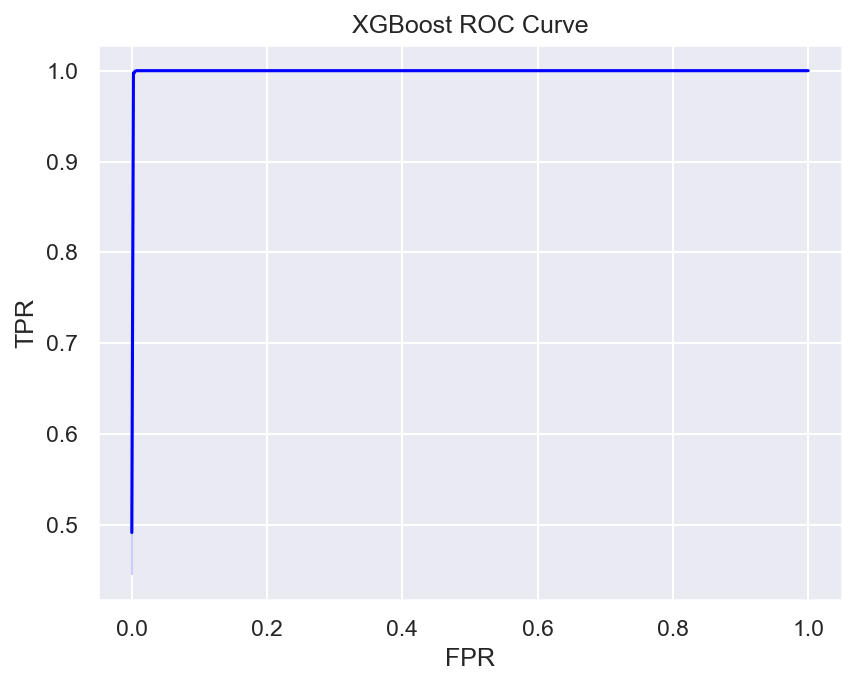

In [12]:
# XGBoost ROC Curve
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

# Plot XGBoost ROC Curve
fig, ax = plt.subplots(dpi=150)
sns.lineplot(x=fpr_xgb, y=tpr_xgb, color='blue', ax=ax)
ax.set_title(f'XGBoost ROC Curve')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()
